# Quantitative Risk Management Assignment

## Import Libraries and Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import os, json, pathlib
import kagglehub
from pathlib import Path
import re

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


## Load Data, Preprocessing, and First Look

In [6]:
path = kagglehub.dataset_download("uciml/default-of-credit-card-clients-dataset")
print("Path to dataset files:", path)

Path to dataset files: /Users/sebastianuedingslohmann/.cache/kagglehub/datasets/uciml/default-of-credit-card-clients-dataset/versions/1


In [7]:
# Load dataset and save as df
base = Path(path)
df = pd.read_csv(base / "UCI_Credit_Card.csv")

In [8]:
print(f'Rows: {df.shape[0]}, Columns: {df.shape[1]}')

Rows: 30000, Columns: 25


In [9]:
display(df.head())

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [10]:
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [11]:
df.isnull().sum().sort_values()

ID                            0
PAY_AMT5                      0
PAY_AMT4                      0
PAY_AMT3                      0
PAY_AMT2                      0
PAY_AMT1                      0
BILL_AMT6                     0
BILL_AMT5                     0
BILL_AMT4                     0
BILL_AMT3                     0
BILL_AMT2                     0
PAY_AMT6                      0
BILL_AMT1                     0
PAY_5                         0
PAY_4                         0
PAY_3                         0
PAY_2                         0
PAY_0                         0
AGE                           0
MARRIAGE                      0
EDUCATION                     0
SEX                           0
LIMIT_BAL                     0
PAY_6                         0
default.payment.next.month    0
dtype: int64

In [12]:
# Change column name of target variable
df = df.rename(columns={"default.payment.next.month": "default"})
df.columns = [re.sub(r"[^\w]", "_", c).strip("_").lower() for c in df.columns]

# Check if target variable has only 0 and 1 values
assert set(df['default'].unique()) == {0, 1}

In [13]:
# Sex
df['sex'].value_counts(dropna=False).sort_index()

sex
1    11888
2    18112
Name: count, dtype: int64

In [14]:
# Education
df['education'].value_counts(dropna=False).sort_index()

education
0       14
1    10585
2    14030
3     4917
4      123
5      280
6       51
Name: count, dtype: int64

In [15]:
# Mapping education values 0, 5, 6 to 7 (unknown) (others remain unchanged)
edu_map = {0: 7, 5: 7, 6: 7}
df["education"] = df["education"].replace(edu_map).astype("int64")
print(df["education"].value_counts().sort_index())

education
1    10585
2    14030
3     4917
4      123
7      345
Name: count, dtype: int64


In [16]:
# Marriage
df['marriage'].value_counts(dropna=False).sort_index()

marriage
0       54
1    13659
2    15964
3      323
Name: count, dtype: int64

In [17]:
# Payment status columns
for c in [col for col in df.columns if re.fullmatch(r"pay_[0-6]", col)]:
    print(f"\n{c}:\n{df[c].value_counts(dropna=False).sort_index()}")


pay_0:
pay_0
-2     2759
-1     5686
 0    14737
 1     3688
 2     2667
 3      322
 4       76
 5       26
 6       11
 7        9
 8       19
Name: count, dtype: int64

pay_2:
pay_2
-2     3782
-1     6050
 0    15730
 1       28
 2     3927
 3      326
 4       99
 5       25
 6       12
 7       20
 8        1
Name: count, dtype: int64

pay_3:
pay_3
-2     4085
-1     5938
 0    15764
 1        4
 2     3819
 3      240
 4       76
 5       21
 6       23
 7       27
 8        3
Name: count, dtype: int64

pay_4:
pay_4
-2     4348
-1     5687
 0    16455
 1        2
 2     3159
 3      180
 4       69
 5       35
 6        5
 7       58
 8        2
Name: count, dtype: int64

pay_5:
pay_5
-2     4546
-1     5539
 0    16947
 2     2626
 3      178
 4       84
 5       17
 6        4
 7       58
 8        1
Name: count, dtype: int64

pay_6:
pay_6
-2     4895
-1     5740
 0    16286
 2     2766
 3      184
 4       49
 5       13
 6       19
 7       46
 8        2
Name: count, dtype

In [18]:
# Bill amount columns
bill_cols = [c for c in df.columns if re.fullmatch(r"bill_amt[1-6]", c)]
df[bill_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
bill_amt1,30000.0,51223.330900,73635.860576,-165580.0,3558.75,22381.5,67091.00,964511.0
bill_amt2,30000.0,49179.075167,71173.768783,-69777.0,2984.75,21200.0,64006.25,983931.0
bill_amt3,30000.0,47013.154800,69349.387427,-157264.0,2666.25,20088.5,60164.75,1664089.0
bill_amt4,30000.0,43262.948967,64332.856134,-170000.0,2326.75,19052.0,54506.00,891586.0
bill_amt5,30000.0,40311.400967,60797.155770,-81334.0,1763.00,18104.5,50190.50,927171.0
bill_amt6,30000.0,38871.760400,59554.107537,-339603.0,1256.00,17071.0,49198.25,961664.0


In [19]:
# Pay amount columns
pay_amt_cols = [c for c in df.columns if re.fullmatch(r"pay_amt[1-6]", c)]
df[pay_amt_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
pay_amt1,30000.0,5663.580500,16563.280354,0.0,1000.00,2100.0,5006.00,873552.0
pay_amt2,30000.0,5921.163500,23040.870402,0.0,833.00,2009.0,5000.00,1684259.0
pay_amt3,30000.0,5225.681500,17606.961470,0.0,390.00,1800.0,4505.00,896040.0
pay_amt4,30000.0,4826.076867,15666.159744,0.0,296.00,1500.0,4013.25,621000.0
pay_amt5,30000.0,4799.387633,15278.305679,0.0,252.50,1500.0,4031.50,426529.0
pay_amt6,30000.0,5215.502567,17777.465775,0.0,117.75,1500.0,4000.00,528666.0


In [20]:
# Check if target variable has only 0 and 1 values
assert set(df['default'].unique()) == {0, 1}

In [21]:
sex_dummies = pd.get_dummies(df["sex"], prefix="sex")
df = pd.concat([df, sex_dummies], axis=1)

In [22]:
marriage_dummies = pd.get_dummies(df["marriage"], prefix="marriage")
df = pd.concat([df, marriage_dummies], axis=1)

In [23]:
edu_dummies = pd.get_dummies(df["education"], prefix="education")
df = pd.concat([df, edu_dummies], axis=1)

In [24]:
# Drop original categorical columns as well as one dummy variable from each to avoid multicollinearity
df = df.drop(columns=['sex', 'sex_2', 'education', 'education_7', 'marriage', 'marriage_3'])
df.head()


,id,limit_bal,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,...,pay_amt6,default,sex_1,marriage_0,marriage_1,marriage_2,education_1,education_2,education_3,education_4
0,1,20000.0,24,2,2,-1,-1,-2,-2,3913.0,...,0.0,1,False,False,True,False,False,True,False,False
1,2,120000.0,26,-1,2,0,0,0,2,2682.0,...,2000.0,1,False,False,False,True,False,True,False,False
2,3,90000.0,34,0,0,0,0,0,0,29239.0,...,5000.0,0,False,False,False,True,False,True,False,False
3,4,50000.0,37,0,0,0,0,0,0,46990.0,...,1000.0,0,False,False,True,False,False,True,False,False
4,5,50000.0,57,-1,0,-1,0,0,0,8617.0,...,679.0,0,True,False,True,False,False,True,False,False


## Feature Engineering

In [54]:
pay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

df['max_late_payment'] = df[pay_cols].max(axis=1)
df['num_late_payments'] = (df[pay_cols] > 0).sum(axis=1)
df['recent_late_payment'] = (df['pay_0'] > 0).astype(int)
df['delay_trend_overall'] = df['pay_0'].clip(lower=0) - df['pay_6'].clip(lower=0)
df['delay_trend_short_term'] = df['pay_0'].clip(lower=0) - df['pay_3'].clip(lower=0)
df['num_fully_paid'] = (df[pay_cols] == -1).sum(axis=1)
df['num_inactive_months'] = (df[pay_cols] == -2).sum(axis=1)
df['pay_volatility'] = df[pay_amt_cols].std(axis=1)
df['max_consecutive_delays'] = df[pay_cols].apply(lambda x: max((x > 0).astype(int).groupby((x <= 0).cumsum()).sum()), axis=1)

In [55]:
bill_cols = ['bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6']

df['bill_mean'] = df[bill_cols].mean(axis=1)
df['bill_std'] = df[bill_cols].std(axis=1)
df['bill_trend'] = df['bill_amt1'] - df['bill_amt6']

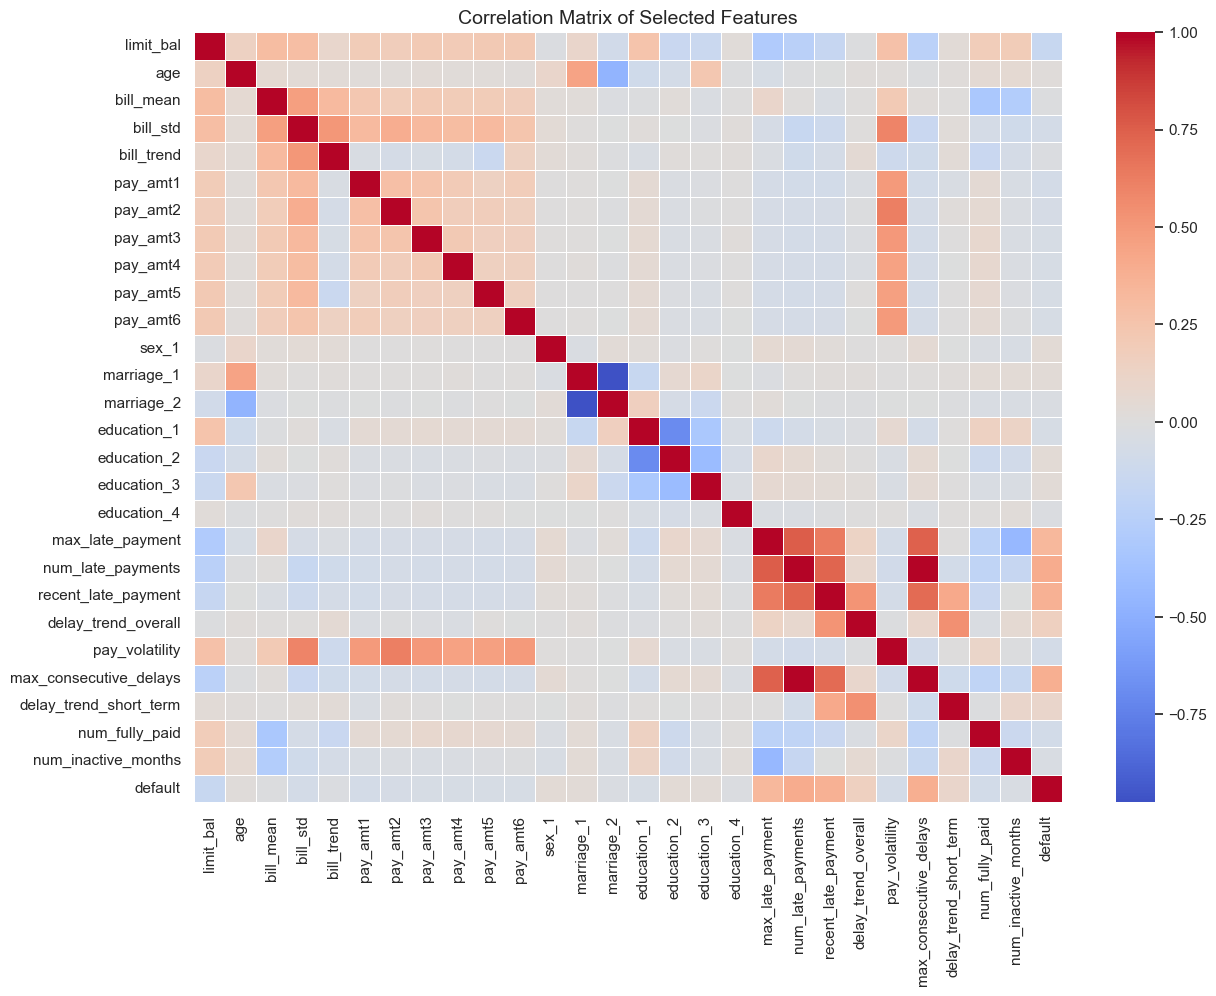

In [59]:
feature_cols = ['limit_bal', 'age', 'bill_mean', 'bill_std', 'bill_trend', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'sex_1', 'marriage_1', 'marriage_2', 'education_1', 'education_2', 'education_3', 'education_4', 'max_late_payment', 'num_late_payments', 'recent_late_payment', 'delay_trend_overall', 'pay_volatility', 'max_consecutive_delays', 'delay_trend_short_term', 'num_fully_paid', 'num_inactive_months']
corr_features = feature_cols + ["default"]

corr = df[corr_features].corr(numeric_only=True)

plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation Matrix of Selected Features", fontsize=14)
plt.show()

- High correlation in features, experimentation showed that they improve accuracy a bit in linear regression
- We must implement regularisation to shrink coefficients of correlated features and multicollinearity is controlled

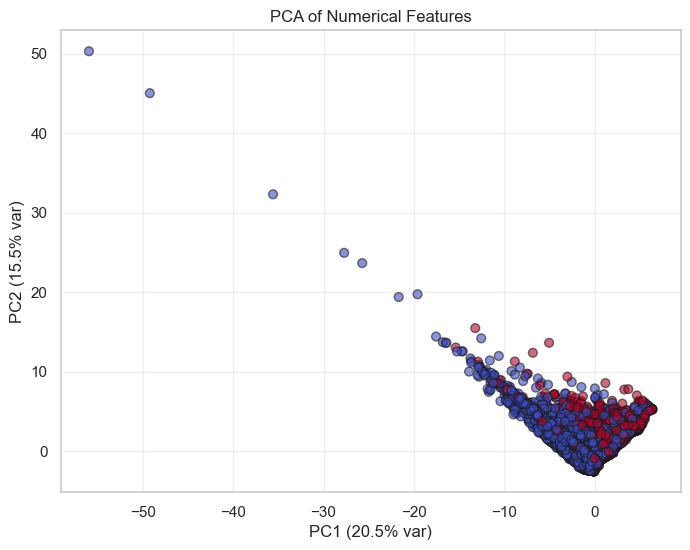

Explained variance ratio: 36.01% (2 components)


In [62]:
numeric_features = [
    'limit_bal', 'age', 'bill_mean', 'bill_std', 'bill_trend',
    'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
    'max_late_payment', 'num_late_payments', 'recent_late_payment',
    'delay_trend_overall', 'pay_volatility', 'max_consecutive_delays',
    'delay_trend_short_term', 'num_fully_paid', 'num_inactive_months']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[numeric_features])

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=df['default'],
    cmap='coolwarm',
    alpha=0.6,
    edgecolors='k',
    s=40)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)')
plt.title('PCA of Numerical Features')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum()*100:.2f}% (2 components)")


- No clear class separation, in 2D PCA plot default and non-default customers are heavily overlapping which indicates that our numerical features do not produce linearly separable structure
- Spectrum of behaviours, no distinct groups
- Moderate explained variance, meaning the feature space is high dimensional with several independent behavioural aspects ratehr than dominant features
- Implications for modeling since classes overlap in the space, we cannot expect high performance from simple linear decision boundaries so we need models that capture non linear structures
- Implication for expectations: Even with good modelling and feature engineering, default prediction in this dataset is likely to remain a noisy problem, we should focus on improviding threshold tuning rather than chasing perfect separation

## Exploratory Data Analysis

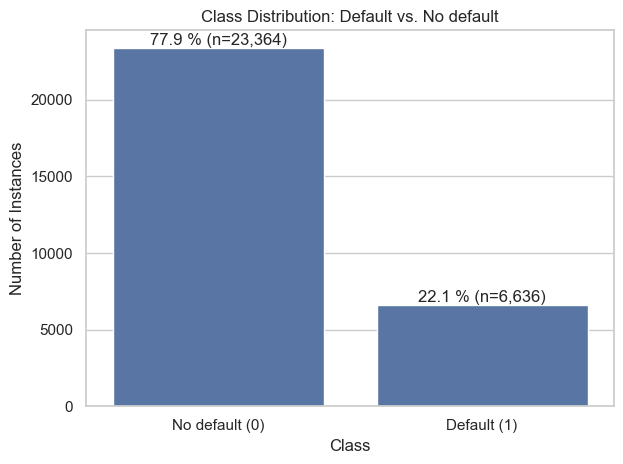

In [28]:
# Visualize the class imbalance in a barplot
sns.set_theme(style="whitegrid")

counts = df["default"].value_counts().sort_index()
pcts   = (df["default"].value_counts(normalize=True)
         .sort_index()
         .mul(100).round(1))

labels = ["No default (0)", "Default (1)"]

ax = sns.barplot(x=labels, y=counts.values)
ax.set_xlabel("Class")
ax.set_ylabel("Number of Instances")
ax.set_title("Class Distribution: Default vs. No default")

for i, (n, p) in enumerate(zip(counts.values, pcts.values)):
    ax.text(i, n, f"{p} % (n={n:,})", ha="center", va="bottom")

plt.tight_layout()
plt.show()

Class_weight = 'balanced' necessary

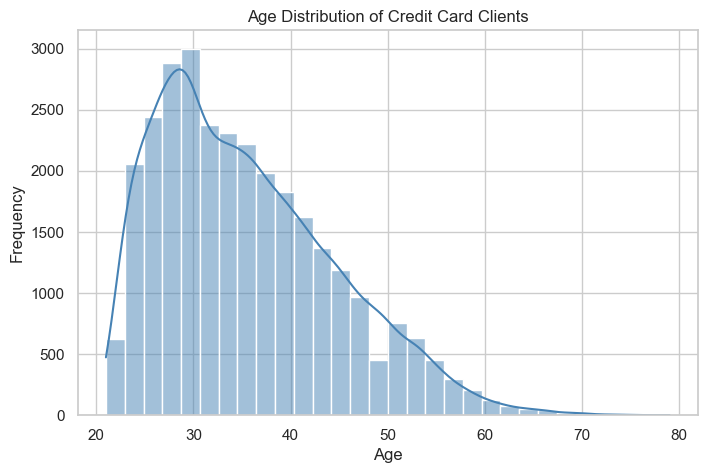

In [29]:
plt.figure(figsize=(8,5))
sns.histplot(df['age'], bins=30, kde=True, color='steelblue')
plt.title('Age Distribution of Credit Card Clients')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

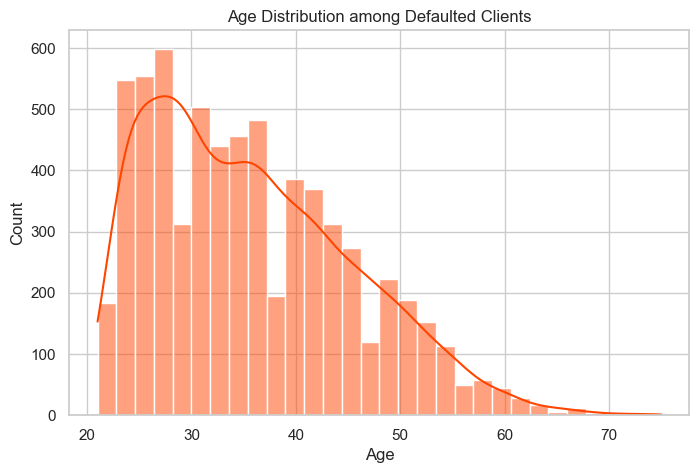

In [30]:
df_default = df[df["default"] == 1]

plt.figure(figsize=(8,5))
sns.histplot(
    data=df_default,
    x="age",
    bins=30,
    kde=True,
    color="orangered",
)
plt.title("Age Distribution among Defaulted Clients")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

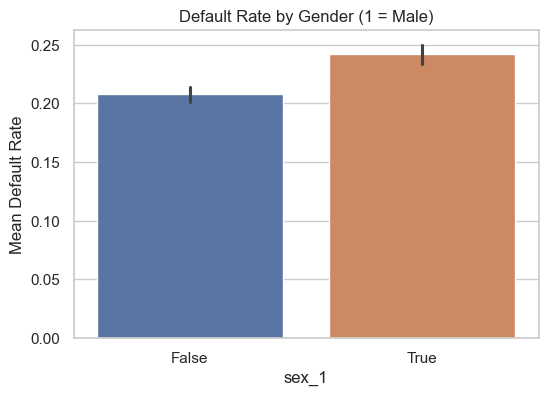

In [31]:
plt.figure(figsize=(6,4))
sns.barplot(data=df, x="sex_1", y="default", estimator=lambda x: np.mean(x), hue = "sex_1", legend = False)
plt.title("Default Rate by Gender (1 = Male)")
plt.ylabel("Mean Default Rate")
plt.show()

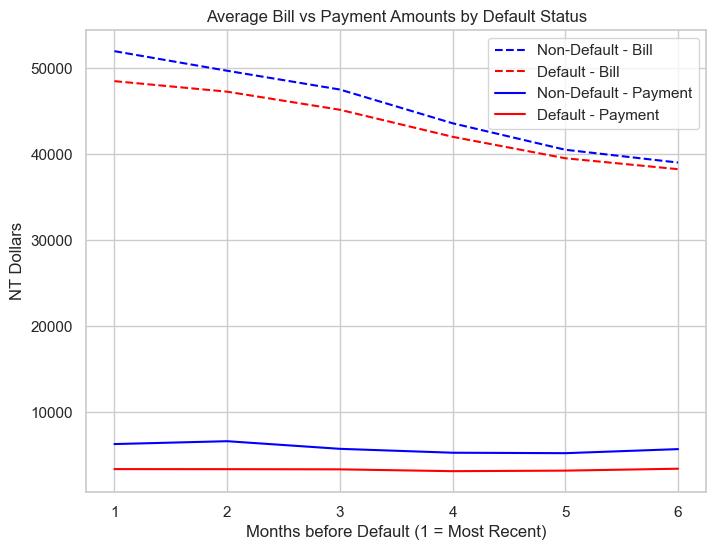

In [32]:
months = np.arange(1, 7)

bill_cols = [f"bill_amt{i}" for i in range(1, 7)]
pay_cols  = [f"pay_amt{i}" for i in range(1, 7)]

mean_bill = df.groupby("default")[bill_cols].mean().T
mean_pay  = df.groupby("default")[pay_cols].mean().T

plt.figure(figsize=(8,6))

# Bill amounts
plt.plot(months, mean_bill.loc[bill_cols, 0], '--', label="Non-Default - Bill", color='blue')
plt.plot(months, mean_bill.loc[bill_cols, 1], '--', label="Default - Bill", color='red')

# Payment amounts
plt.plot(months, mean_pay.loc[pay_cols, 0], '-', label="Non-Default - Payment", color='blue')
plt.plot(months, mean_pay.loc[pay_cols, 1], '-', label="Default - Payment", color='red')

plt.title("Average Bill vs Payment Amounts by Default Status")
plt.xlabel("Months before Default (1 = Most Recent)")
plt.ylabel("NT Dollars")
plt.legend()
plt.show()

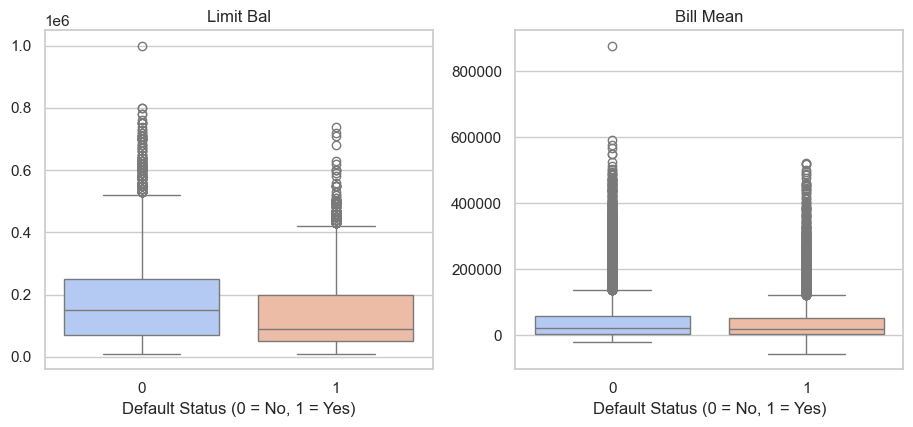

In [33]:
features = ['limit_bal', 'bill_mean']

# Layout vorbereiten
plt.figure(figsize=(14, 8))
for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(
        data=df,
        x='default',
        y=col,
        palette='coolwarm',
        hue = 'default',
        legend = False,
    )
    plt.title(col.replace('_', ' ').title())
    plt.xlabel('Default Status (0 = No, 1 = Yes)')
    plt.ylabel('')
plt.tight_layout()
plt.show()

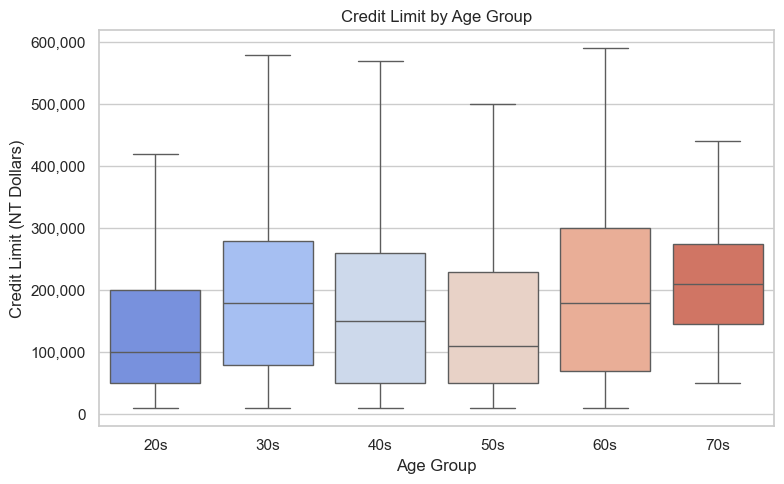

In [34]:
df["age_group"] = pd.cut(
    df["age"],
    bins=[20, 30, 40, 50, 60, 70, 80],
    labels=["20s", "30s", "40s", "50s", "60s", "70s"])

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df,
    x="age_group",
    y="limit_bal",
    palette="coolwarm",
    hue="age_group",
    legend = False,
    showfliers=False)

plt.title("Credit Limit by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Credit Limit (NT Dollars)")

formatter = FuncFormatter(lambda x, _: f"{int(x):,}")
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

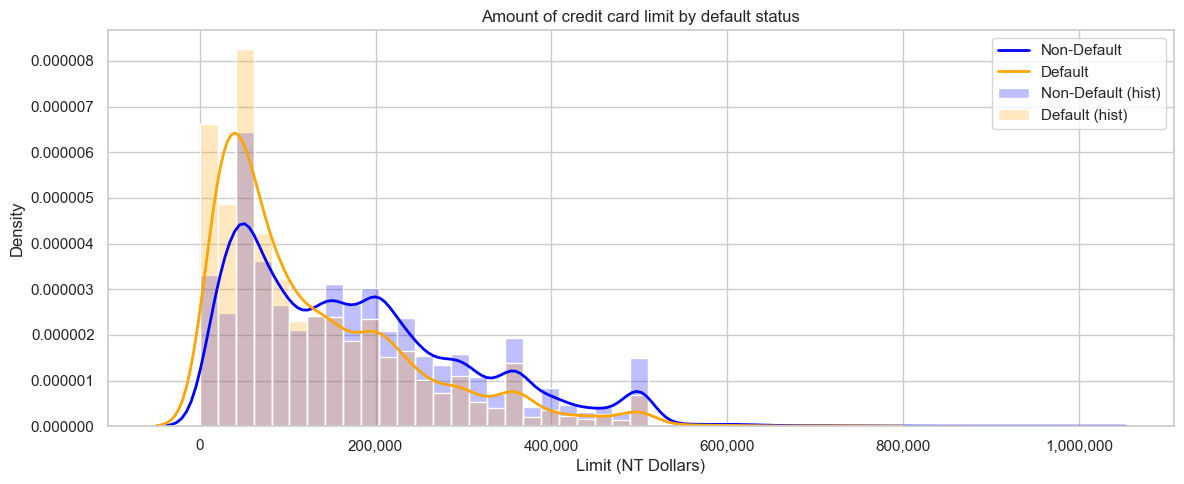

In [35]:
plt.figure(figsize=(12, 5))

bins = np.linspace(0, df["limit_bal"].max(), 50)

sns.histplot(
    df.loc[df["default"] == 0, "limit_bal"],
    bins=bins,
    stat="density",
    color="blue",
    alpha=0.25,
    label="Non-Default (hist)")
sns.kdeplot(
    df.loc[df["default"] == 0, "limit_bal"],
    color="blue",
    lw=2,
    label="Non-Default")

sns.histplot(
    df.loc[df["default"] == 1, "limit_bal"],
    bins=bins,
    stat="density",
    color="orange",
    alpha=0.25,
    label="Default (hist)")
sns.kdeplot(
    df.loc[df["default"] == 1, "limit_bal"],
    color="orange",
    lw=2,
    label="Default")

plt.title("Amount of credit card limit by default status")
plt.xlabel("Limit (NT Dollars)")
plt.ylabel("Density")

x_formatter = FuncFormatter(lambda x, _: f"{int(x):,}")
plt.gca().xaxis.set_major_formatter(x_formatter)

plt.ticklabel_format(axis="y", style="plain")

plt.legend()
plt.tight_layout()
plt.show()


Leaving features even if there is some correlation, will be taken care of by L2 regularisation.

## Modeling

In [67]:
y = df['default'].astype('int64')
X = df[feature_cols]

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [69]:
scale_cols = numeric_features

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test_scaled[scale_cols] = scaler.transform(X_test[scale_cols])

### 1. Logistic regression (class_weight)

In [83]:
log_reg = LogisticRegression(max_iter = 3000, random_state = 42, class_weight = 'balanced')

In [84]:
param_grid = [
    # L1 Regularization (Lasso)
    {
        'penalty': ['l1'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear']
    },
    # L2 Regularization (Ridge)
    {
        'penalty': ['l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear']
    },
    # ElasticNet (combination of L1 and L2)
    {
        'penalty': ['elasticnet'],
        'C': [0.001, 0.01, 0.1, 1, 10],
        'solver': ['saga'], # supports elastic net
        'l1_ratio': [0.2, 0.5, 0.8]
    }]

# Perform Grid Search with F1 Score as the evaluation metric
grid = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring=make_scorer(f1_score),
    cv=5,
    n_jobs=-1,
    verbose=2)

grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END ................C=0.1, penalty=l1, sol

,estimator,LogisticRegre...ndom_state=42)
,param_grid,"[{'C': [0.001, 0.01, ...], 'penalty': ['l1'], 'solver': ['liblinear']}, {'C': [0.001, 0.01, ...], 'penalty': ['l2'], 'solver': ['liblinear']}, ...]"
,scoring,make_scorer(f...hod='predict')
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'elasticnet'


In [85]:
print("Best parameters:", grid.best_params_)
print("Best F1 (CV):", grid.best_score_)

best_model = grid.best_estimator_

Best parameters: {'C': 0.01, 'l1_ratio': 0.2, 'penalty': 'elasticnet', 'solver': 'saga'}
Best F1 (CV): 0.5314409487603908


In [86]:
proba = best_model.predict_proba(X_test_scaled)[:, 1]
pred = (proba >= 0.5).astype(int)

In [87]:
print("ROC-AUC:", round(roc_auc_score(y_test, proba), 4))
print("\nConfusion matrix:\n", confusion_matrix(y_test, pred))
print("\nReport:\n", classification_report(y_test, pred, digits=3))

ROC-AUC: 0.7507

Confusion matrix:
 [[3769  904]
 [ 552  775]]

Report:
               precision    recall  f1-score   support

           0      0.872     0.807     0.838      4673
           1      0.462     0.584     0.516      1327

    accuracy                          0.757      6000
   macro avg      0.667     0.695     0.677      6000
weighted avg      0.781     0.757     0.767      6000



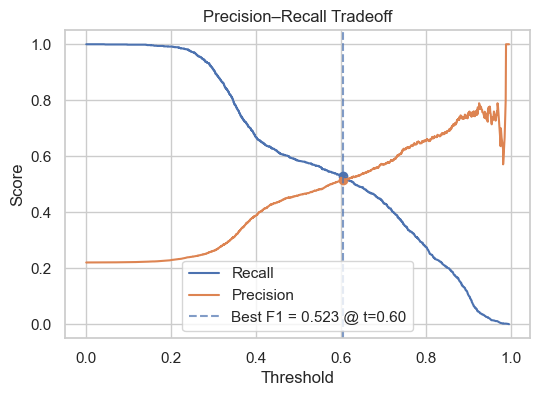

Best threshold: 0.603
Precision: 0.516, Recall: 0.531, F1: 0.523


In [ ]:
prec, rec, thresh = precision_recall_curve(y_test, proba)

f1 = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-8)
best_idx = np.argmax(f1)
best_thresh = thresh[best_idx]
best_prec = prec[:-1][best_idx]
best_rec = rec[:-1][best_idx]
best_f1 = f1[best_idx]

plt.figure(figsize=(6,4))
plt.plot(thresh, rec[:-1], label='Recall')
plt.plot(thresh, prec[:-1], label='Precision')

plt.axvline(best_thresh, linestyle='--', alpha=0.7,
            label=f'Best F1 = {best_f1:.3f} @ t={best_thresh:.2f}')
plt.scatter(best_thresh, best_rec, marker='o')
plt.scatter(best_thresh, best_prec, marker='o')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision–Recall Tradeoff')
plt.legend()
plt.show()

print(f"Best threshold: {best_thresh:.3f}")
print(f"Precision: {best_prec:.3f}, Recall: {best_rec:.3f}, F1: {best_f1:.3f}")

### 2. Logistic Regression (SMOTE oversampling)

In [94]:
best_params = grid.best_params_.copy()
best_params['max_iter'] = 3000
best_params['random_state'] = 42


# apply SMOTE oversampling
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_scaled, y_train)

# same model as before but without class_weight
model_smote = LogisticRegression(
    penalty = best_params['penalty'],
    C = best_params['C'],
    solver = best_params['solver'],
    max_iter = 3000,
    random_state = 42,
    class_weight = None,
    l1_ratio = best_params.get('l1_ratio', None))
model_smote.fit(X_train_sm, y_train_sm)

proba_sm = model_smote.predict_proba(X_test_scaled)[:, 1]
pred_sm = (proba_sm >= 0.5).astype(int)

print("ROC-AUC:", round(roc_auc_score(y_test, proba_sm), 4))
print(confusion_matrix(y_test, pred_sm))
print(classification_report(y_test, pred_sm, digits=3))


ROC-AUC: 0.7505
[[3822  851]
 [ 557  770]]
              precision    recall  f1-score   support

           0      0.873     0.818     0.844      4673
           1      0.475     0.580     0.522      1327

    accuracy                          0.765      6000
   macro avg      0.674     0.699     0.683      6000
weighted avg      0.785     0.765     0.773      6000



### 3. XGBoost

In [43]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(len(y_train[y_train==0]) / len(y_train[y_train==1])),  # Klassenbalance
    eval_metric='auc',
    random_state=42,
    n_jobs=-1)

xgb.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [ ]:
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

ROC-AUC: 0.7771649445716715

Confusion matrix:
 [[3686  987]
 [ 484  843]]

Classification report:
               precision    recall  f1-score   support

           0       0.88      0.79      0.83      4673
           1       0.46      0.64      0.53      1327

    accuracy                           0.75      6000
   macro avg       0.67      0.71      0.68      6000
weighted avg       0.79      0.75      0.77      6000



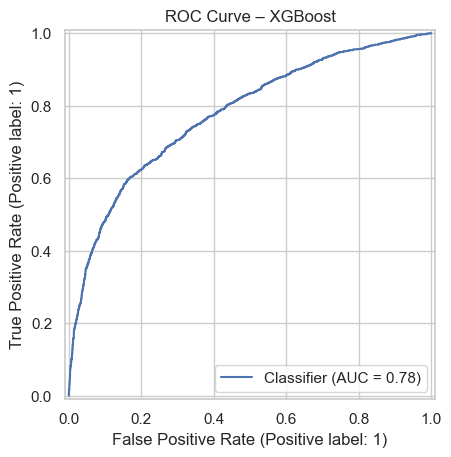

In [44]:
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve – XGBoost")
plt.show()

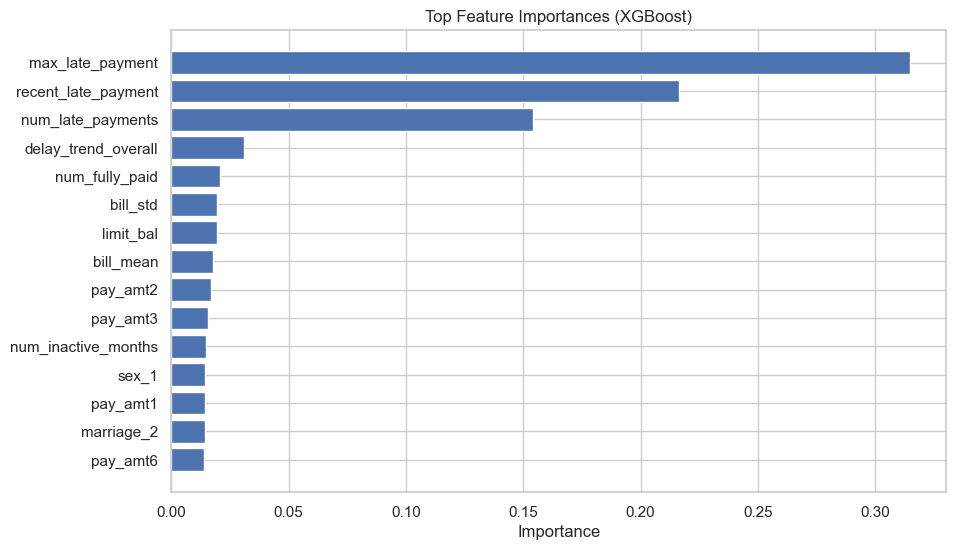

In [45]:
importances = xgb.feature_importances_
features = X_train.columns

plt.figure(figsize=(10,6))
sorted_idx = importances.argsort()[::-1][:15]  # Top 15 Features
plt.barh(features[sorted_idx][::-1], importances[sorted_idx][::-1])
plt.title("Top Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.show()

### 4. Multilayer Perceptron

In [46]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')])

/Users/sebastianuedingslohmann/Desktop/QRM/Risk-Management/.venv64/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [47]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])


In [48]:
early_stop = EarlyStopping(monitor='val_auc', patience=6, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1)


Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7414 - auc: 0.6773 - loss: 0.5629 - val_accuracy: 0.7996 - val_auc: 0.7575 - val_loss: 0.4588
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - accuracy: 0.8055 - auc: 0.7399 - loss: 0.4619 - val_accuracy: 0.8081 - val_auc: 0.7718 - val_loss: 0.4487
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - accuracy: 0.8084 - auc: 0.7494 - loss: 0.4525 - val_accuracy: 0.8054 - val_auc: 0.7722 - val_loss: 0.4484
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - accuracy: 0.8114 - auc: 0.7551 - loss: 0.4473 - val_accuracy: 0.8071 - val_auc: 0.7744 - val_loss: 0.4476
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - accuracy: 0.8104 - auc: 0.7603 - loss: 0.4427 - val_accuracy: 0.8083 - val_auc: 0.7761 - val_loss: 0.4464
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - accuracy: 0.8147 - auc: 0.7622 - loss: 0.4413 - val_accuracy: 0.8096 - val_auc: 0.7772 - val_loss: 0.4439
Epoch 7/30
300/300 ━━━━━━━━━━━

In [49]:
y_pred_proba = model.predict(X_test_scaled).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
ROC-AUC: 0.7725363892785617

Confusion Matrix:
 [[4399  274]
 [ 837  490]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89      4673
           1       0.64      0.37      0.47      1327

    accuracy                           0.81      6000
   macro avg       0.74      0.66      0.68      6000
weighted avg       0.80      0.81      0.80      6000



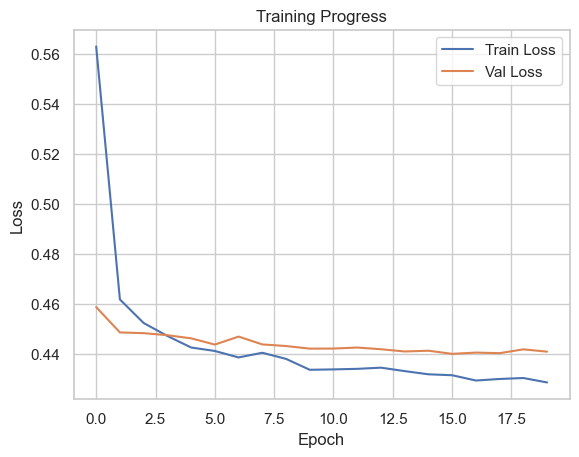

In [51]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


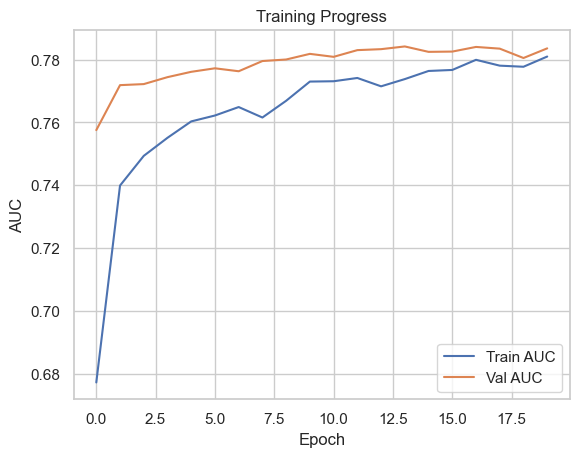

In [52]:
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('Training Progress')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()